In [1]:
!pip install -q kaggle
!pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 2.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imanuelanatalia","key":"fec2d93b148f4cf3f2bdf3263d170c02"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           6490        192  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1163         30  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4308        100  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [7]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset
!kaggle datasets download -d adinishad/prediction-images

100% 2.17G/2.17G [00:12<00:00, 203MB/s]
100% 2.17G/2.17G [00:12<00:00, 191MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 105MB/s]


In [8]:
!unzip drowsiness-prediction-dataset.zip
!unzip prediction-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: 0 FaceImages/Active Subjects/img_k_12330.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12360.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12390.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12420.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12450.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12480.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12510.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12540.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12570.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12600.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12630.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12660.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12690.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12720.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12750.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_1

In [15]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

In [28]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) # flatten and remove duplicates
print("Left eye landmarks:", all_left_eye_idxs)

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs)) # flatten and remove duplicates
print("Right eye landmarks:", all_right_eye_idxs)

# Combined for plotting use - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)



Left eye landmarks: {384, 385, 386, 387, 388, 390, 263, 362, 398, 466, 373, 374, 249, 380, 381, 382}
Right eye landmarks: {160, 33, 161, 163, 133, 7, 173, 144, 145, 246, 153, 154, 155, 157, 158, 159}


In [32]:
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [52]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )

 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )

 
    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE)) 
    return resized_array

In [53]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.

    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame

    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, frame_width, frame_height)
            coords_points.append(coord)

        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points

In [54]:
imgH, imgW, _=0,0,0 
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
                            
     # Running inference using static_image_mode 
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:  
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [55]:
def face_for_yawn(direc="/content/0 FaceImages", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [56]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [57]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3669


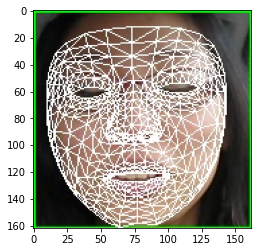

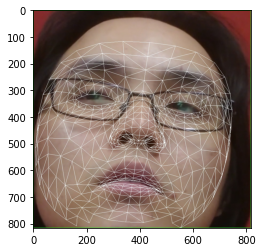

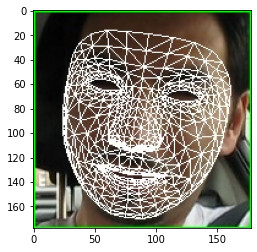

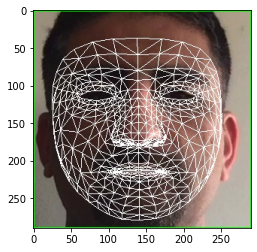

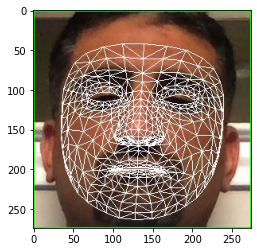

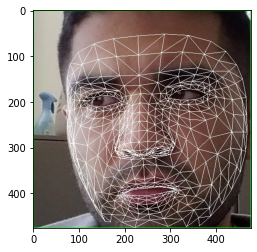

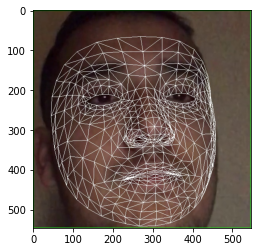

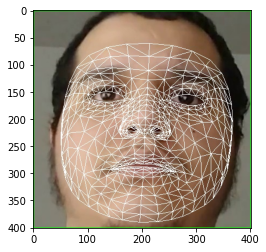

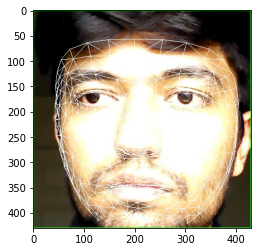

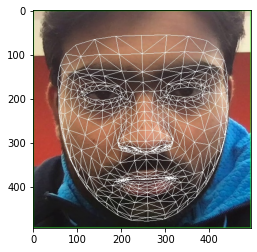

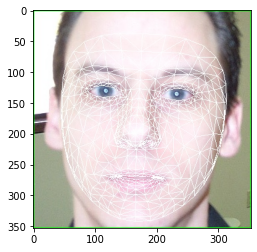

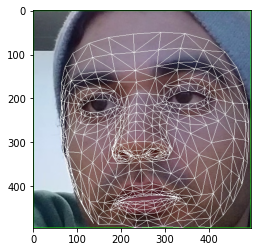

In [69]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      img_file = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
      plt.imshow(img_file)
      plt.show()
      plt.close()

In [70]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [78]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

In [79]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [80]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

In [81]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [82]:
len(X_test)

1508

In [83]:
len(X_train)

6030

In [86]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [101]:
import tensorflow as tf
import keras
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout

In [102]:

# Model Elsafty 1

model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 143, 143, 16)      448       
                                                                 
 batch_normalization_9 (Batc  (None, 143, 143, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 71, 71, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 67, 67, 32)        12832     
                                                                 
 batch_normalization_10 (Bat  (None, 67, 67, 32)       128       
 chNormalization)                                                
                                                      

In [104]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
189/189 [==============================] - 303s 2s/step - loss: 0.5247 - accuracy: 0.7370 - val_loss: 1.5295 - val_accuracy: 0.5113
Epoch 2/70
189/189 [==============================] - 299s 2s/step - loss: 0.4490 - accuracy: 0.7716 - val_loss: 0.7300 - val_accuracy: 0.6638
Epoch 3/70
189/189 [==============================] - 298s 2s/step - loss: 0.4134 - accuracy: 0.7955 - val_loss: 0.5349 - val_accuracy: 0.7076
Epoch 4/70
189/189 [==============================] - 298s 2s/step - loss: 0.3619 - accuracy: 0.8299 - val_loss: 0.6284 - val_accuracy: 0.6592
Epoch 5/70
189/189 [==============================] - 298s 2s/step - loss: 0.3207 - accuracy: 0.8556 - val_loss: 0.4155 - val_accuracy: 0.7958
Epoch 6/70
189/189 [==============================] - 298s 2s/step - loss: 0.2988 - accuracy: 0.8695 - val_loss: 0.4113 - val_accuracy: 0.8110
Epoch 7/70
189/189 [==============================] - 295s 2s/step - loss: 0.2661 - accuracy: 0.8856 - val_loss: 0.5406 - val_accuracy: 0.7845

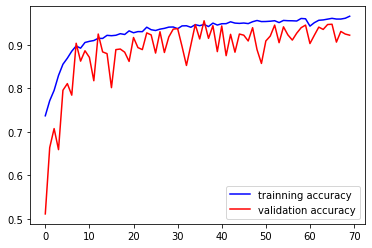

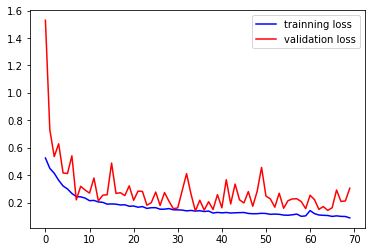

In [105]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [106]:
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 [==============================] - 18s 381ms/step - loss: 0.3040 - accuracy: 0.9224


{'loss': 0.3040049970149994, 'accuracy': 0.9224137663841248}

In [107]:
model.save('my_model.h5')

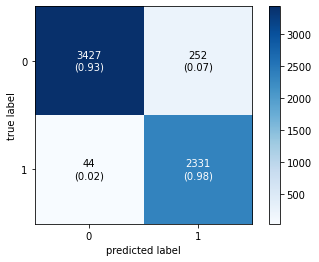

In [108]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()